In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import statsmodels.api as sm

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import corpora
from gensim.models import LdaModel

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 경로
TWEET_PATH = r"C:\Users\jinuk\OneDrive\문서\카카오톡 받은 파일\trump_tweets_2016_2021_final.csv"
PRICE_PATH = r"C:\Users\jinuk\SPXUSD_filtered.xlsx"

# 기간(논문)
START_UTC = pd.Timestamp("2016-11-08", tz="UTC")
END_UTC   = pd.Timestamp("2019-09-22 23:59:59", tz="UTC")

horizons = [1, 10, 20, 30, 45, 60, 120]
NUM_TOPICS = 20
TOPIC_ID = 0

In [2]:
tweets_raw = pd.read_csv(TWEET_PATH)

tweets_raw["datetime_utc"] = pd.to_datetime(tweets_raw["datetime_utc"], utc=True, errors="coerce")
tweets_raw = tweets_raw.dropna(subset=["datetime_utc", "text"]).copy()

# 기간 필터 (UTC aware 상태에서)
tweets_raw = tweets_raw[(tweets_raw["datetime_utc"] >= START_UTC) & (tweets_raw["datetime_utc"] <= END_UTC)].copy()

# tz-naive로 통일
tweets_raw["datetime_utc"] = tweets_raw["datetime_utc"].dt.tz_localize(None)
tweets_raw["minute"] = tweets_raw["datetime_utc"].dt.floor("min")

tweets_raw = tweets_raw.reset_index(drop=True)
print("트윗 개수:", len(tweets_raw))
tweets_raw.head()


트윗 개수: 8846


,datetime_utc,id,text,retweets,favorites,minute
0,2016-11-08 06:42:00,795879172795203584,Today we are going to win the great state of M...,14011,45371,2016-11-08 06:42:00
1,2016-11-08 11:43:00,795954831718498305,TODAY WE MAKE AMERICA GREAT AGAIN!,281289,498035,2016-11-08 11:43:00
2,2016-11-08 16:39:00,796029413318082560,VOTE TODAY! Go to https://t.co/MXrAxYnTjY to f...,24105,55870,2016-11-08 16:39:00
3,2016-11-08 18:03:00,796050609254395905,We need your vote. Go to the POLLS! Let's cont...,19145,51888,2016-11-08 18:03:00
4,2016-11-08 18:23:00,796055597594578944,#ElectionDay https://t.co/MXrAxYnTjY https://t...,20111,51371,2016-11-08 18:23:00


In [3]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"@\w+", " ", text)
    text = text.replace("#", " ")
    return text

def tokenize(text: str):
    return simple_preprocess(clean_text(text), deacc=True, min_len=3)

tokenized = [tokenize(t) for t in tweets_raw["text"]]

bigram = Phrases(tokenized, min_count=5, threshold=10)
bigram_mod = Phraser(bigram)
token_bi = [bigram_mod[doc] for doc in tokenized]

def remove_stop(tokens):
    return [w for w in tokens if w not in stop_words]

def stem(tokens):
    return [stemmer.stem(w) for w in tokens]

token_clean_all = [stem(remove_stop(doc)) for doc in token_bi]

# 빈 문서 제거 + df 동기화 (여기가 제일 중요)
keep_mask = [len(doc) > 0 for doc in token_clean_all]
tweets_lda = tweets_raw.loc[keep_mask].reset_index(drop=True)
token_clean = [doc for doc, k in zip(token_clean_all, keep_mask) if k]

print("동기화 확인:", len(tweets_lda), len(token_clean))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jinuk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


동기화 확인: 8630 8630


In [4]:
dictionary = corpora.Dictionary(token_clean)
corpus = [dictionary.doc2bow(doc) for doc in token_clean]

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=42,
    passes=10,
    chunksize=2000,
    alpha="auto",
    eta="auto"
)


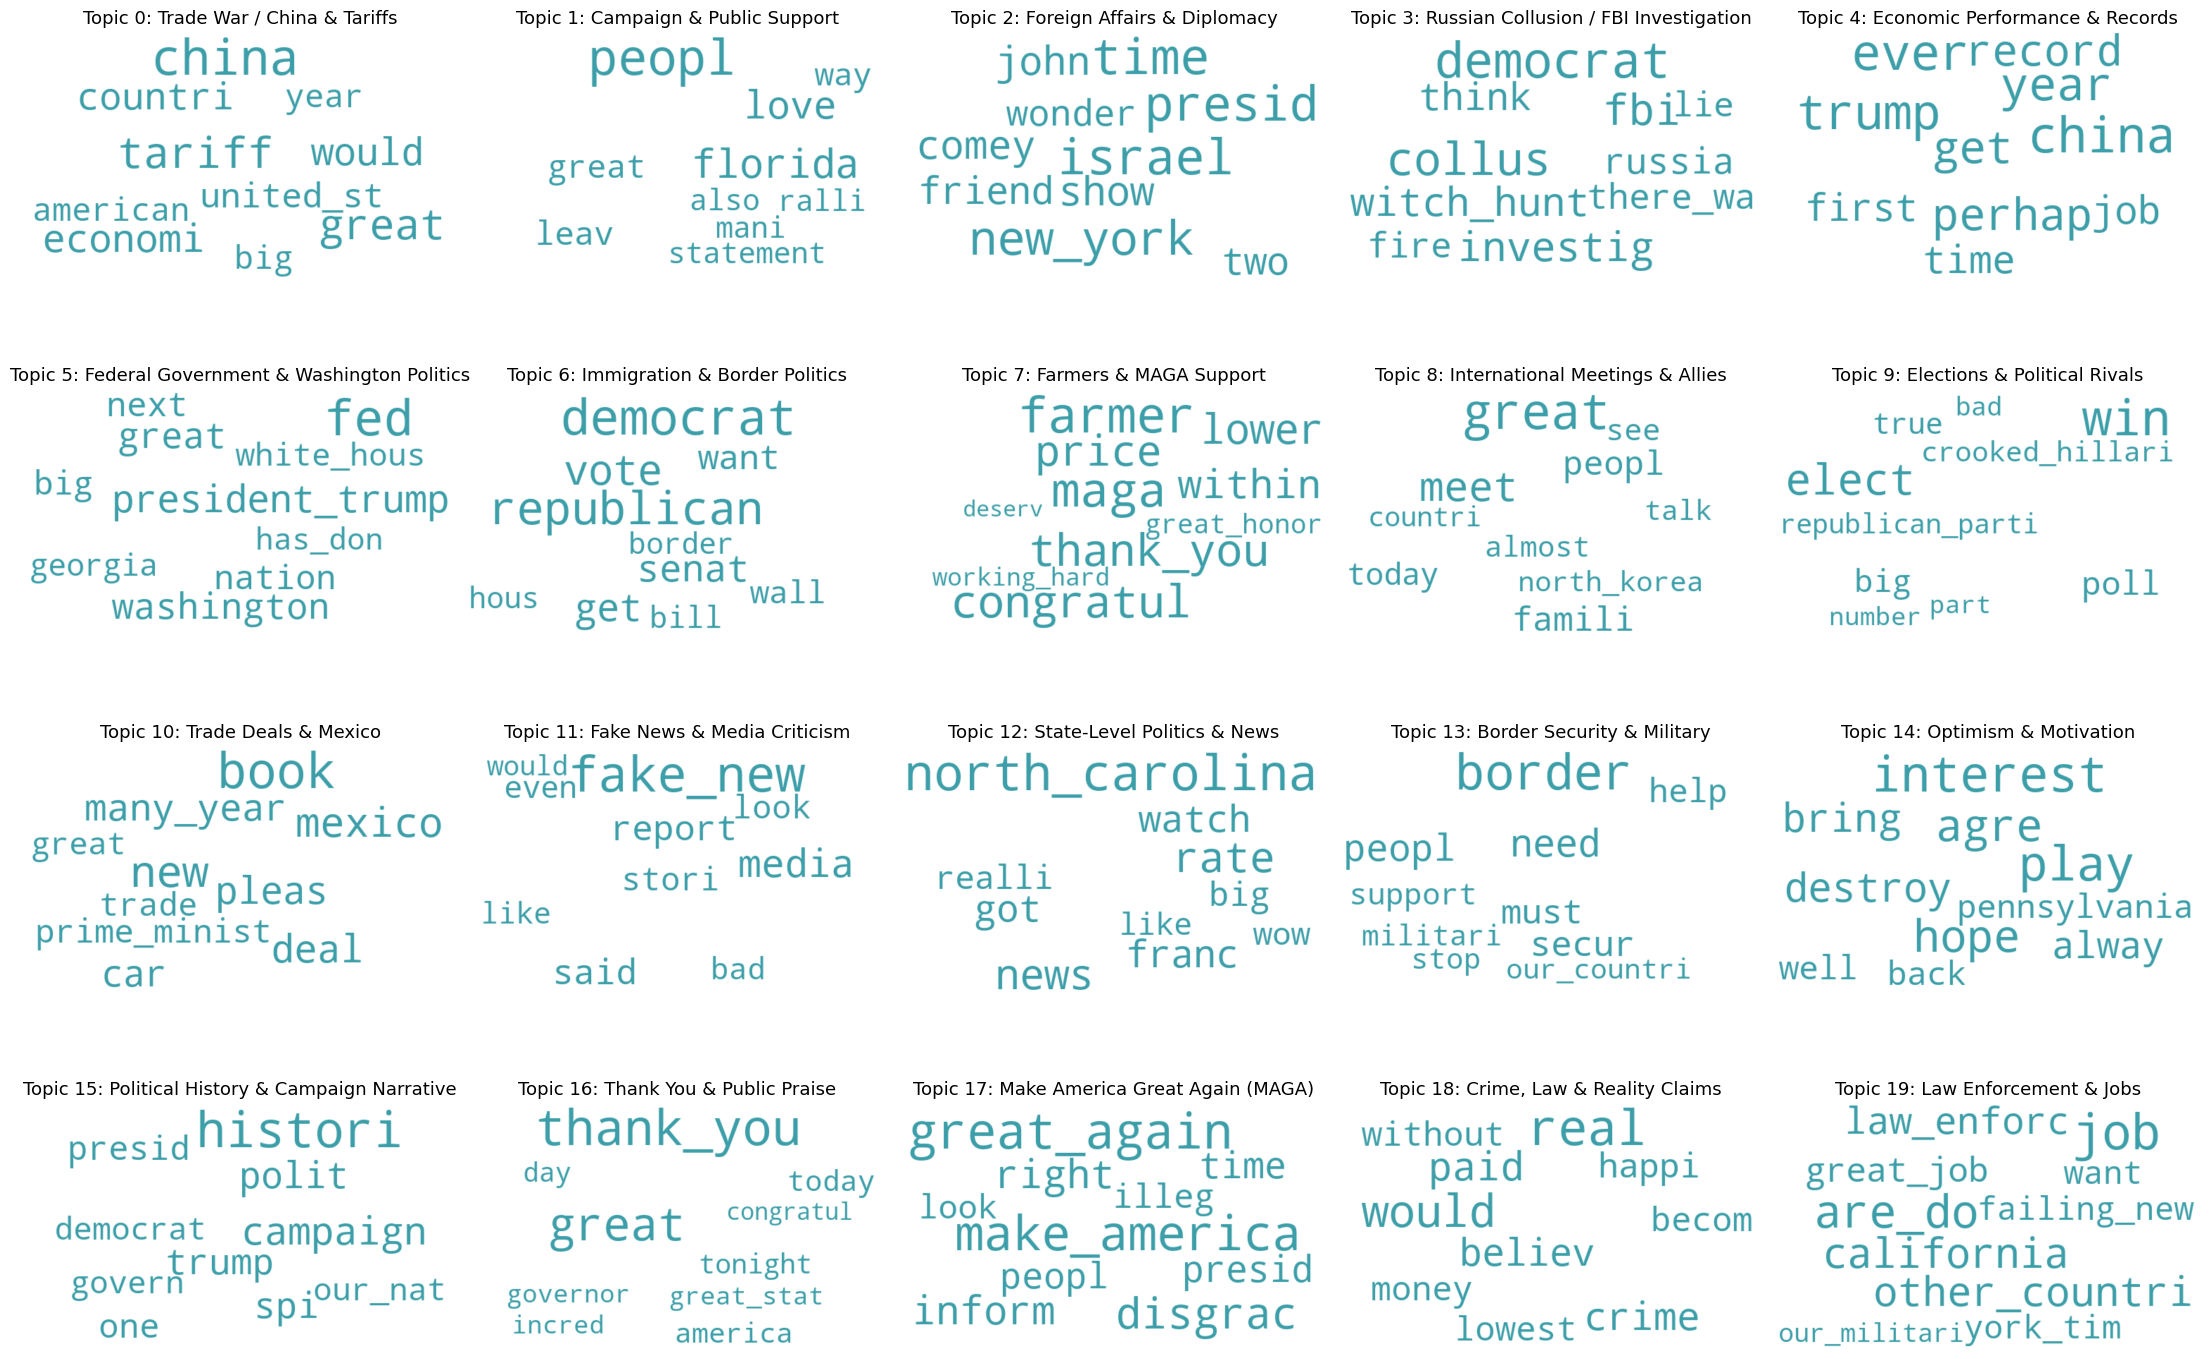

In [14]:
# ================================
# Topic 이름 정의
# ================================
topic_names = {
    0: "Trade War / China & Tariffs",
    1: "Campaign & Public Support",
    2: "Foreign Affairs & Diplomacy",
    3: "Russian Collusion / FBI Investigation",
    4: "Economic Performance & Records",
    5: "Federal Government & Washington Politics",
    6: "Immigration & Border Politics",
    7: "Farmers & MAGA Support",
    8: "International Meetings & Allies",
    9: "Elections & Political Rivals",
    10: "Trade Deals & Mexico",
    11: "Fake News & Media Criticism",
    12: "State-Level Politics & News",
    13: "Border Security & Military",
    14: "Optimism & Motivation",
    15: "Political History & Campaign Narrative",
    16: "Thank You & Public Praise",
    17: "Make America Great Again (MAGA)",
    18: "Crime, Law & Reality Claims",
    19: "Law Enforcement & Jobs"
}

def teal_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "#3b9ea8"

fig, axes = plt.subplots(4, 5, figsize=(22, 15))
axes = axes.flatten()

for topic_id in range(NUM_TOPICS):
    topic = lda_model.show_topic(topic_id, topn=10)
    freqs = {word: weight for word, weight in topic}

    wc = WordCloud(
        width=600, height=350,
        background_color="white",
        max_words=10,
        prefer_horizontal=1.0,
        min_font_size=14,
        max_font_size=70,
        relative_scaling=0.5,
        collocations=False,
        color_func=teal_color_func,
        random_state=42
    ).generate_from_frequencies(freqs)

    ax = axes[topic_id]
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(
    f"Topic {topic_id}: {topic_names.get(topic_id, '')}",
    fontsize=13
)

plt.tight_layout()
plt.show()


In [29]:
from collections import Counter
import pandas as pd

# token_clean : 전처리 + bigram + stopword 제거 + stemming까지 끝난 리스트
# 형태: List[List[str]]

# 1) 전체 토큰 평탄화
all_tokens = [w for doc in token_clean for w in doc]

# 2) 단어 빈도 계산
word_counts = Counter(all_tokens)

# 3) 상위 20개 단어
top20_words = word_counts.most_common(20)

# 4) DataFrame으로 정리
df_top20 = pd.DataFrame(top20_words, columns=["word", "count"])

print("=== 전처리 기준 단어 빈도 TOP 20 ===")
print(df_top20)


=== 전처리 기준 단어 빈도 TOP 20 ===
           word  count
0         great   1506
1         peopl    961
2      democrat    682
3     thank_you    633
4           get    578
5           big    565
6         would    549
7      fake_new    549
8   our_countri    538
9        presid    528
10        today    492
11         time    460
12         year    454
13         want    439
14          job    435
15         mani    430
16       border    411
17        china    395
18         work    391
19      countri    389


In [30]:
from gensim.models.coherencemodel import CoherenceModel

# c_v coherence (가장 많이 쓰이는 지표)
coherence_model = CoherenceModel(
    model=lda_model,
    texts=token_clean,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()
print(f"Coherence (c_v): {coherence_score:.4f}")


Coherence (c_v): 0.3720


In [6]:
price = pd.read_excel(PRICE_PATH)
price["datetime"] = pd.to_datetime(price["datetime"], errors="coerce")
price = price.dropna(subset=["datetime"]).set_index("datetime").sort_index()

open_candidates = [c for c in price.columns if c.lower() == "open"]
if not open_candidates:
    raise ValueError(f"price에 open 컬럼이 없습니다. price.columns={list(price.columns)}")
OPEN_COL = open_candidates[0]

# 수익률 생성 (open 기준)
for h in horizons:
    price[f"open_fwd_{h}m"] = price[OPEN_COL].shift(-h)
    price[f"ret_{h}m"] = price[f"open_fwd_{h}m"] / price[OPEN_COL] - 1

# 분당 트윗 개수(더미용)
tweet_counts = tweets_raw.groupby("minute").size().rename("n_tweets").to_frame()
tweet_counts.index.name = "datetime"

data = price.join(tweet_counts, how="left")
data["tweet_dummy"] = (data["n_tweets"].fillna(0) > 0).astype(int)

print("data:", data.shape)
data[[OPEN_COL, "n_tweets", "tweet_dummy", "ret_1m"]].head()


data: (790517, 22)


,open,n_tweets,tweet_dummy,ret_1m
datetime,,,,
2016-11-07 00:02:00,2105.50,NaN,0,0.000119
2016-11-07 00:03:00,2105.75,NaN,0,0.000237
2016-11-07 00:04:00,2106.25,NaN,0,-0.000237
2016-11-07 00:05:00,2105.75,NaN,0,0.000119
2016-11-07 00:12:00,2106.00,NaN,0,0.000119


In [7]:
def get_topic_prob(model, bow, topic_id):
    dist = dict(model.get_document_topics(bow, minimum_probability=0))
    return float(dist.get(topic_id, 0.0))

# 문서별 topic0 확률
topic0_probs = [get_topic_prob(lda_model, bow, TOPIC_ID) for bow in corpus]
tweets_lda["topic0_prob"] = topic0_probs

# 분단위 max 집계
topic0_minute = (
    tweets_lda.groupby("minute")["topic0_prob"]
             .max()
             .to_frame("topic0")
)
topic0_minute.index.name = "datetime"

print(topic0_minute.head())


                       topic0
datetime                     
2016-11-08 06:42:00  0.018463
2016-11-08 11:43:00  0.035838
2016-11-08 16:39:00  0.018496
2016-11-08 18:03:00  0.016888
2016-11-08 18:23:00  0.083307


In [42]:
import pandas as pd
import statsmodels.api as sm

horizons = [1, 10, 20, 30, 45, 60, 120]
TOPIC_ID = 0

# df_lda 대신 tweets_lda를 사용
df_lda = tweets_lda.copy()

assert len(df_lda) == len(corpus), f"길이 불일치: df_lda={len(df_lda)}, corpus={len(corpus)}"

def get_topic_prob(model, bow, topic_id):
    dist = dict(model.get_document_topics(bow, minimum_probability=0))
    return float(dist.get(topic_id, 0.0))

# minute (이미 tz-naive인 상태)
df_lda["minute"] = pd.to_datetime(df_lda["datetime_utc"], errors="coerce").dt.floor("min")

# topic0_prob
df_lda["topic0_prob"] = [get_topic_prob(lda_model, bow, TOPIC_ID) for bow in corpus]

# minute별 max
topic0_minute = df_lda.groupby("minute")["topic0_prob"].max().to_frame("topic0")
topic0_minute.index.name = "datetime"

print("Trade War_minute 생성 완료:", topic0_minute.shape)
print("Trade War_minute 요약:\n", topic0_minute["topic0"].describe())

# 이벤트: median 이상
q = topic0_minute["topic0"].median()
events = topic0_minute[topic0_minute["topic0"] >= q].reset_index().rename(columns={"datetime": "event_time_utc"})
events["event_time_utc"] = pd.to_datetime(events["event_time_utc"], errors="coerce")

# UTC → ET
events["event_time_utc"] = events["event_time_utc"].dt.tz_localize("UTC")
events["event_time_et"] = events["event_time_utc"].dt.tz_convert("America/New_York")

# RTH 필터(문자열 기준)
events["dow"] = events["event_time_et"].dt.dayofweek
events["time_str"] = events["event_time_et"].dt.strftime("%H:%M")
events_rth = events[
    (events["dow"] <= 4) &
    (events["time_str"] >= "09:30") &
    (events["time_str"] <= "16:00")
].copy()

print("정규장 이벤트 수:", len(events_rth))

# px 준비 (data는 tz-naive 가정)
px = data.reset_index().rename(columns={"datetime": "px_time_utc"}).copy()
px["px_time_utc"] = pd.to_datetime(px["px_time_utc"], errors="coerce").dt.tz_localize("UTC")
px["px_time_et"] = px["px_time_utc"].dt.tz_convert("America/New_York")

px = px.sort_values("px_time_et").reset_index(drop=True)
events_rth = events_rth.sort_values("event_time_et").reset_index(drop=True)

# asof 매칭
matched = pd.merge_asof(
    events_rth,
    px,
    left_on="event_time_et",
    right_on="px_time_et",
    direction="forward",
    tolerance=pd.Timedelta("2min")
).dropna(subset=["px_time_et"]).copy()

matched = matched.sort_values("px_time_et").reset_index(drop=True)
print("매칭 성공 이벤트 수:", len(matched))

# overlap 제거 (MIN_GAP=10 고정)
def drop_overlaps(df, time_col):
    MIN_GAP = 10
    df = df.sort_values(time_col).reset_index(drop=True).copy()
    keep = []
    last_time = None
    for t in df[time_col]:
        if last_time is None or (t - last_time) >= pd.Timedelta(minutes=MIN_GAP):
            keep.append(True)
            last_time = t
        else:
            keep.append(False)
    return df.loc[keep].reset_index(drop=True).copy()

# 회귀
rows = []
for h in horizons:
    mh = drop_overlaps(matched, "px_time_et")

    y = mh[f"ret_{h}m"]
    X = sm.add_constant(mh[["topic0"]])

    mask = y.notna()
    res = sm.RLM(y[mask], X[mask], M=sm.robust.norms.HuberT()).fit()

    rows.append({
        "horizon_min": h,
        "events_used": int(res.nobs),
        "beta_Trade War": float(res.params["topic0"]),
        "p_Trade War": float(res.pvalues["topic0"])
    })

res_event_original = pd.DataFrame(rows)
print(res_event_original)


Trade War_minute 생성 완료: (8093, 1)
Trade War_minute 요약:
 count    8093.000000
mean        0.092079
std         0.131135
min         0.006095
25%         0.013306
50%         0.023005
75%         0.126307
max         0.872231
Name: topic0, dtype: float64
정규장 이벤트 수: 911
매칭 성공 이벤트 수: 621
   horizon_min  events_used  beta_Trade War  p_Trade War
0            1          568        0.000057     0.296135
1           10          568        0.000104     0.532843
2           20          568       -0.000027     0.908511
3           30          568       -0.000056     0.852740
4           45          568       -0.000495     0.179889
5           60          568       -0.000683     0.108368
6          120          568       -0.000708     0.270027


In [41]:
import pandas as pd
import statsmodels.api as sm

horizons = [1, 10, 20, 30, 45, 60, 120]
TOPIC_ID = 10  # ✅ topic10으로 변경

# df_lda / corpus / lda_model / data 는 이미 위에서 만든 상태라고 가정
df_lda = tweets_lda.copy()
assert len(df_lda) == len(corpus), f"길이 불일치: df_lda={len(df_lda)}, corpus={len(corpus)}"

def get_topic_prob(model, bow, topic_id):
    dist = dict(model.get_document_topics(bow, minimum_probability=0))
    return float(dist.get(topic_id, 0.0))

# minute (이미 tz-naive)
df_lda["minute"] = pd.to_datetime(df_lda["datetime_utc"], errors="coerce").dt.floor("min")

# topic10_prob
topic_col = f"topic{TOPIC_ID}"
df_lda[topic_col] = [get_topic_prob(lda_model, bow, TOPIC_ID) for bow in corpus]

# minute별 max
topic_minute = df_lda.groupby("minute")[topic_col].max().to_frame(topic_col)
topic_minute.index.name = "datetime"
print("topic10_minute 생성 완료:", topic_minute.shape)
print("topic10_minute 요약:\n", topic_minute[topic_col].describe())

# 이벤트: median 이상
q = topic_minute[topic_col].median()
events = topic_minute[topic_minute[topic_col] >= q].reset_index().rename(columns={"datetime": "event_time_utc"})
events["event_time_utc"] = pd.to_datetime(events["event_time_utc"], errors="coerce")

# UTC → ET
events["event_time_utc"] = events["event_time_utc"].dt.tz_localize("UTC")
events["event_time_et"] = events["event_time_utc"].dt.tz_convert("America/New_York")

# RTH 필터
events["dow"] = events["event_time_et"].dt.dayofweek
events["time_str"] = events["event_time_et"].dt.strftime("%H:%M")
events_rth = events[
    (events["dow"] <= 4) &
    (events["time_str"] >= "09:30") &
    (events["time_str"] <= "16:00")
].copy()

print("정규장 이벤트 수:", len(events_rth))

# px 준비 (data는 tz-naive)
px = data.reset_index().rename(columns={"datetime": "px_time_utc"}).copy()
px["px_time_utc"] = pd.to_datetime(px["px_time_utc"], errors="coerce").dt.tz_localize("UTC")
px["px_time_et"] = px["px_time_utc"].dt.tz_convert("America/New_York")

px = px.sort_values("px_time_et").reset_index(drop=True)
events_rth = events_rth.sort_values("event_time_et").reset_index(drop=True)

# asof 매칭
matched = pd.merge_asof(
    events_rth,
    px,
    left_on="event_time_et",
    right_on="px_time_et",
    direction="forward",
    tolerance=pd.Timedelta("2min")
).dropna(subset=["px_time_et"]).copy()

matched = matched.sort_values("px_time_et").reset_index(drop=True)
print("매칭 성공 이벤트 수:", len(matched))

# overlap 제거 (MIN_GAP=10 고정)
def drop_overlaps(df, time_col):
    MIN_GAP = 10
    df = df.sort_values(time_col).reset_index(drop=True).copy()
    keep = []
    last_time = None
    for t in df[time_col]:
        if last_time is None or (t - last_time) >= pd.Timedelta(minutes=MIN_GAP):
            keep.append(True)
            last_time = t
        else:
            keep.append(False)
    return df.loc[keep].reset_index(drop=True).copy()

# 회귀
rows = []
for h in horizons:
    mh = drop_overlaps(matched, "px_time_et")

    y = mh[f"ret_{h}m"]
    X = sm.add_constant(mh[[topic_col]])  # ✅ topic10 넣기

    mask = y.notna()
    res = sm.RLM(y[mask], X[mask], M=sm.robust.norms.HuberT()).fit()

    rows.append({
        "horizon_min": h,
        "events_used": int(res.nobs),
        "beta_topic10": float(res.params[topic_col]),
        "p_topic10": float(res.pvalues[topic_col])
    })

res_event_topic10 = pd.DataFrame(rows)
print(res_event_topic10)


topic10_minute 생성 완료: (8093, 1)
topic10_minute 요약:
 count    8093.000000
mean        0.038099
std         0.076636
min         0.002925
25%         0.005621
50%         0.008116
75%         0.021433
max         0.700622
Name: topic10, dtype: float64
정규장 이벤트 수: 984
매칭 성공 이벤트 수: 660
   horizon_min  events_used  beta_topic10  p_topic10
0            1          607  1.655734e-04   0.056843
1           10          607 -3.994469e-07   0.998750
2           20          607 -2.840970e-04   0.427194
3           30          607  2.673779e-04   0.568999
4           45          607  1.345452e-04   0.814145
5           60          607  2.248066e-04   0.740054
6          120          607 -4.084056e-04   0.683432


In [34]:
import pandas as pd
import re
import statsmodels.api as sm

# =========================
# 설정
# =========================
horizons = [1, 10, 20, 30, 45, 60, 120]

# =========================
# 0) tariff 단어 이벤트 만들기 (tweets_raw 사용)
# =========================
tweets = tweets_raw.copy()
tweets["datetime_utc"] = pd.to_datetime(tweets["datetime_utc"], errors="coerce")
tweets = tweets.dropna(subset=["datetime_utc", "text"]).copy()

# 분 단위
tweets["minute"] = tweets["datetime_utc"].dt.floor("min")

# tariff 단어 탐지 (파생형 포함 가능)
pat = re.compile(r"\btariff(s|ed|ing)?\b", flags=re.IGNORECASE)
tweets["is_tariff"] = tweets["text"].astype(str).apply(
    lambda x: 1 if pat.search(x) else 0
)

# minute별 tariff 등장 여부
tariff_minute = (
    tweets.groupby("minute")["is_tariff"]
          .max()
          .to_frame("Tariff_t")
)
tariff_minute.index.name = "datetime"

print("tariff 등장 분 수 (UTC):", tariff_minute["Tariff_t"].sum())

# =========================
# 1) 가격 데이터 준비 + ET 변환
# =========================
px = data.reset_index().rename(columns={"datetime": "px_time_utc"}).copy()
px["px_time_utc"] = pd.to_datetime(px["px_time_utc"], errors="coerce")
px = px.dropna(subset=["px_time_utc"]).copy()

px["px_time_utc"] = px["px_time_utc"].dt.tz_localize("UTC")
px["px_time_et"]  = px["px_time_utc"].dt.tz_convert("America/New_York")

# 정렬
px = px.sort_values("px_time_et").reset_index(drop=True)

# =========================
# 2) 정규장(RTH) 필터
# =========================
px["dow"] = px["px_time_et"].dt.dayofweek
px["time_str"] = px["px_time_et"].dt.strftime("%H:%M")

px_rth = px[
    (px["dow"] <= 4) &
    (px["time_str"] >= "09:30") &
    (px["time_str"] <= "16:00")
].copy()

print("RTH 분 수:", len(px_rth))

# =========================
# 3) tariff 이벤트를 RTH 분에 매핑
tariff_flag = tariff_minute.reset_index().copy()

# 1️⃣ UTC에서 먼저 floor
tariff_flag["px_time_utc"] = (
    pd.to_datetime(tariff_flag["datetime"], errors="coerce")
    .dt.floor("min")
    .dt.tz_localize("UTC")
)

# 2️⃣ 그 다음 ET로 변환
tariff_flag["px_time_et"] = tariff_flag["px_time_utc"].dt.tz_convert("America/New_York")

tariff_flag = tariff_flag[["px_time_et", "Tariff_t"]]


px_rth = px_rth.merge(
    tariff_flag,
    on="px_time_et",
    how="left"
)

px_rth["Tariff_t"] = px_rth["Tariff_t"].fillna(0).astype(int)


# =========================
# 4) 회귀: ret_{h}m = a + b * Tariff_t + e
# =========================
rows = []

for h in horizons:
    y = px_rth[f"ret_{h}m"]
    X = sm.add_constant(px_rth[["Tariff_t"]])

    mask = y.notna()
    res = sm.RLM(
        y[mask],
        X[mask],
        M=sm.robust.norms.HuberT()
    ).fit()

    rows.append({
        "horizon_min": h,
        "beta_tariff": float(res.params["Tariff_t"]),
        "p_tariff": float(res.pvalues["Tariff_t"]),
        "obs": int(res.nobs)
    })

res_tariff_current = pd.DataFrame(rows)

print("\n=== Tariff 단어 회귀 결과 (현재 메커니즘) ===")
print(res_tariff_current)


tariff 등장 분 수 (UTC): 150
RTH 분 수: 161548

=== Tariff 단어 회귀 결과 (현재 메커니즘) ===
   horizon_min  beta_tariff  p_tariff     obs
0            1     0.000047  0.247333  161548
1           10    -0.000172  0.178092  161548
2           20    -0.000481  0.008004  161548
3           30    -0.000621  0.005115  161548
4           45    -0.000865  0.001366  161548
5           60    -0.001022  0.001002  161548
6          120    -0.001196  0.005431  161548


In [36]:
import pandas as pd
import re
import statsmodels.api as sm

# =========================
# 설정
# =========================
horizons = [1, 10, 20, 30, 45, 60, 120]
WORDS = {
    "china": r"\bchina\b",
    "deal":  r"\bdeal(s|ed|ing)?\b"
}

# =========================
# 0) 단어 이벤트 만들기 (tweets_raw 사용)
# =========================
tweets = tweets_raw.copy()
tweets["datetime_utc"] = pd.to_datetime(tweets["datetime_utc"], errors="coerce")
tweets = tweets.dropna(subset=["datetime_utc", "text"]).copy()
tweets["minute"] = tweets["datetime_utc"].dt.floor("min")

word_minute_dict = {}

for word, pattern in WORDS.items():
    pat = re.compile(pattern, flags=re.IGNORECASE)
    tweets[f"is_{word}"] = tweets["text"].astype(str).apply(
        lambda x: 1 if pat.search(x) else 0
    )

    wm = (
        tweets.groupby("minute")[f"is_{word}"]
              .max()
              .to_frame(f"{word}_t")
    )
    wm.index.name = "datetime"
    word_minute_dict[word] = wm

    print(f"{word} 등장 분 수 (UTC):", wm[f"{word}_t"].sum())

# =========================
# 1) 가격 데이터 준비 + ET 변환
# =========================
px = data.reset_index().rename(columns={"datetime": "px_time_utc"}).copy()
px["px_time_utc"] = pd.to_datetime(px["px_time_utc"], errors="coerce")
px = px.dropna(subset=["px_time_utc"]).copy()

px["px_time_utc"] = px["px_time_utc"].dt.tz_localize("UTC")
px["px_time_et"]  = px["px_time_utc"].dt.tz_convert("America/New_York")

px = px.sort_values("px_time_et").reset_index(drop=True)

# =========================
# 2) 정규장(RTH) 필터
# =========================
px["dow"] = px["px_time_et"].dt.dayofweek
px["time_str"] = px["px_time_et"].dt.strftime("%H:%M")

px_rth = px[
    (px["dow"] <= 4) &
    (px["time_str"] >= "09:30") &
    (px["time_str"] <= "16:00")
].copy()

print("RTH 분 수:", len(px_rth))

# =========================
# 3) 단어 이벤트를 RTH 분에 매핑
# =========================
for word, wm in word_minute_dict.items():
    flag = wm.reset_index().copy()

    # UTC에서 floor → ET 변환 (DST 안전)
    flag["px_time_utc"] = (
        pd.to_datetime(flag["datetime"], errors="coerce")
        .dt.floor("min")
        .dt.tz_localize("UTC")
    )
    flag["px_time_et"] = flag["px_time_utc"].dt.tz_convert("America/New_York")

    flag = flag[["px_time_et", f"{word}_t"]]

    px_rth = px_rth.merge(flag, on="px_time_et", how="left")
    px_rth[f"{word}_t"] = px_rth[f"{word}_t"].fillna(0).astype(int)


# =========================
# 4) 회귀: ret_{h}m = a + b * Word_t + e
# =========================
results = []

for word in WORDS.keys():
    for h in horizons:
        y = px_rth[f"ret_{h}m"]
        X = sm.add_constant(px_rth[[f"{word}_t"]])

        mask = y.notna()
        res = sm.RLM(
            y[mask],
            X[mask],
            M=sm.robust.norms.HuberT()
        ).fit()

        results.append({
            "word": word,
            "horizon_min": h,
            "beta": float(res.params[f"{word}_t"]),
            "p_value": float(res.pvalues[f"{word}_t"]),
            "obs": int(res.nobs)
        })

res_word_compare = pd.DataFrame(results)

print("\n=== china / deal 단어 회귀 결과 (현재 메커니즘) ===")
print(res_word_compare)

china 등장 분 수 (UTC): 256
deal 등장 분 수 (UTC): 320
RTH 분 수: 161548

=== china / deal 단어 회귀 결과 (현재 메커니즘) ===
     word  horizon_min          beta   p_value     obs
0   china            1  1.775639e-05  0.523855  161548
1   china           10 -6.049340e-07  0.994459  161548
2   china           20 -2.318673e-04  0.061112  161548
3   china           30 -1.213681e-04  0.422203  161548
4   china           45 -4.233752e-04  0.021509  161548
5   china           60 -2.993624e-04  0.157770  161548
6   china          120 -2.659189e-04  0.364711  161548
7    deal            1  1.733443e-05  0.543432  161548
8    deal           10 -1.336060e-04  0.134244  161548
9    deal           20 -2.349585e-04  0.063884  161548
10   deal           30 -4.032465e-05  0.794559  161548
11   deal           45 -2.344815e-04  0.213760  161548
12   deal           60 -1.953690e-04  0.367982  161548
13   deal          120 -4.005579e-04  0.182465  161548
